# Electronic Computing Device Price Prediction Using Machine Learning
Author: Zhuo Fan Chen(P2100746) | Singapore Polytechnic

## Problem Statement
How can we make use of machine learning to help potential computer buyers and vendors to evaluate market price/worth of a computer?

## Problem Understanding

Before launch of an electronic computing product ,the specifications of the products are usually leaked out.With a price predictor,potential consumers will be able to know its estimate price and make a more informed decision when deciding whether to purchase the product.

Additionally,many computers buyers do not know the market price of the computer of that specification and bought the product from external vendors at an overpriced price.Therefore, a price predictor can allow these buyers to have a rough estimation on the average price of product of similar specifications and decide whether is it worth to make the purchase.


Lastly ,it also allows electronic product manufacture to have a rough estimate of the market price of this type of product.


A price of a computer may depend on many factors.Such factors include:Central unit processor(CPU),RAM size,brand etc.

In this investigation,we will evaluate a regression model that has the highest performance in predicting the price of computers based on the relevant features.


## Import Dependencies

In [314]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
sns.set()

import phik
# Experimental
from sklearn.experimental import enable_halving_search_cv, enable_hist_gradient_boosting

# Base Classes
from sklearn.base import BaseEstimator, TransformerMixin

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve
from statsmodels.api import qqplot
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PolynomialFeatures, OneHotEncoder, PowerTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import LinearSVR

# Hyperparameter Tuning
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV, validation_curve, RandomizedSearchCV


# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, SequentialFeatureSelector, VarianceThreshold, mutual_info_regression, RFE

## Data Ingestion

In [315]:
pcDf=pd.read_csv('./pc_data (regression).csv')
pcDf

,Product ID,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight,Price ($)
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,3568.93416
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,2394.77616
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,1531.80000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,6759.76680
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,4804.79040
...,...,...,...,...,...,...,...,...,...,...,...,...
15315,15315,Lenovo,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,1706.40200
15316,15316,Lenovo,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,4000.10600
15317,15317,Lenovo,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,616.82600
15318,15318,HP,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,2042.06600


At first glance,we observed:
- The product ID may not be useful in prediction since the product ID for every product is different
- There is missing data in some rows
- The naming of some data that supposed to be referring to the same thing are named differently.Example: For the macOS in the operating system feature ,some rows are named Mac OS X while other rows named macOS.
-Some features are containing too much information that should be split
- The data type for some features can be changed

## Data Exploration Analysis (EDA)
Before creating the machine learning model, we will carry out the Exploratory Data Analysis (EDA). The exploratory data analysis was proposed by Tukey (1977).It is an approach of analyzing data to gain further discoveries from data and provide a basis for further data preparation and experiment.

### Dataset Information
 This dataset was in xxx.This dataset consists of 1 target label(price) and 11 independent features.15,320 rows of data are found in this dataset.Therefore,we conclude that the size of the dataset is neither too small nor too big.

### Data Dictionary







### Data Structure

In [316]:
pcDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15320 entries, 0 to 15319
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product ID        15320 non-null  int64  
 1   Brand             15320 non-null  object 
 2   Type              15320 non-null  object 
 3   Screen Size       15320 non-null  float64
 4   Screen Specs      15320 non-null  object 
 5   CPU               15320 non-null  object 
 6   RAM               15320 non-null  object 
 7   Hard Disk         15320 non-null  object 
 8   GPU               15320 non-null  object 
 9   Operating System  15320 non-null  object 
 10  Weight            15320 non-null  object 
 11  Price ($)         15320 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 1.4+ MB


By viewing the basic information of the dataset,we realised 2 problem
 - Some feature's data type is incorrect. (E.g. Features such as weight should be more appropriate in float64 form)
 - There is missing data but not identified by default Pandas.  (E.g. The data type of many features is object which is abnormal but total non-null count is still 15320.)

### Feature Engineering


#### Data Categorization

In [317]:
objectEngineer=['Brand','Type','Screen Specs','CPU','RAM','Hard Disk','GPU','Operating System','Weight']

In [318]:
for i in objectEngineer:
    display(pd.DataFrame(pd.unique(pcDf[i]),columns=[i]))

,Brand
0,Apple
1,HP
2,Acer
3,Asus
4,Dell
5,Lenovo
6,Chuwi
7,MSI
8,Microsoft
9,Toshiba


,Type
0,Ultrabook
1,Notebook
2,Netbook
3,Gaming
4,2 in 1 Convertible
5,Workstation


,Screen Specs
0,IPS Panel Retina Display 2560x1600
1,1440x900
2,Full HD 1920x1080
3,IPS Panel Retina Display 2880x1800
4,1366x768
5,IPS Panel Full HD 1920x1080
6,IPS Panel Retina Display 2304x1440
7,IPS Panel Full HD / Touchscreen 1920x1080
8,Full HD / Touchscreen 1920x1080
9,Touchscreen / Quad HD+ 3200x1800


,CPU
0,Intel Core i5 2.3GHz
1,Intel Core i5 1.8GHz
2,Intel Core i5 7200U 2.5GHz
3,Intel Core i7 2.7GHz
4,Intel Core i5 3.1GHz
...,...
113,Intel Celeron Dual Core N3350 2GHz
114,Samsung Cortex A72&A53 2.0GHz
115,AMD E-Series 9000 2.2GHz
116,Intel Core M 6Y30 0.9GHz


,RAM
0,8GB
1,16GB
2,4GB
3,2GB
4,12GB
5,6GB
6,32GB
7,24GB
8,64GB


,Hard Disk
0,128GB SSD
1,128GB Flash Storage
2,256GB SSD
3,512GB SSD
4,500GB HDD
5,256GB Flash Storage
6,1TB HDD
7,32GB Flash Storage
8,128GB SSD + 1TB HDD
9,256GB SSD + 256GB SSD


,GPU
0,Intel Iris Plus Graphics 640
1,Intel HD Graphics 6000
2,Intel HD Graphics 620
3,AMD Radeon Pro 455
4,Intel Iris Plus Graphics 650
...,...
105,Nvidia Quadro M500M
106,AMD Radeon R7 M360
107,Nvidia Quadro M3000M
108,Nvidia GeForce 960M


,Operating System
0,macOS
1,No OS
2,Windows 10
3,Mac OS X
4,Linux
5,Android
6,Windows 10 S
7,Chrome OS
8,Windows 7


,Weight
0,1.37kg
1,1.34kg
2,1.86kg
3,1.83kg
4,2.1kg
...,...
174,2.21kg
175,3.3kg
176,2.191kg
177,2.34kg


In [319]:
pcDf.Weight=pcDf.Weight.replace({'kg':''},regex=True)
pcDf.RAM=pcDf.RAM.replace({'GB':''},regex=True)


In [320]:
pcDf['Operating System']=pcDf['Operating System'].replace({'Windows 10 S':'Windows 10','Mac OS X':'macOS'},regex=True)
pcDf

,Product ID,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight,Price ($)
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,3568.93416
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,2394.77616
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,1531.80000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,6759.76680
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,4804.79040
...,...,...,...,...,...,...,...,...,...,...,...,...
15315,15315,Lenovo,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4,128GB SSD,Intel HD Graphics 520,Windows 10,1.8,1706.40200
15316,15316,Lenovo,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16,512GB SSD,Intel HD Graphics 520,Windows 10,1.3,4000.10600
15317,15317,Lenovo,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5,616.82600
15318,15318,HP,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19,2042.06600


In [321]:
pcDf['Hard Disk']=pcDf['Hard Disk'].replace({'TB':'000',"GB":'',},regex=True)
index=pcDf['Hard Disk'].index
testDf=pcDf.copy()
typeDisk=['SSD','Flash Storage','HDD','Hybrid']
diskDf=pd.DataFrame(0, columns=typeDisk, index=index)
for i,k in enumerate(testDf['Hard Disk']):
   flag1=0
   td=k

   for s in typeDisk:
       if s in k:
          test=td.split(' '+s,1)
          if any("+" in n for n in test):
              if not flag1:
                td=td.split('+ ',1)[1]
              flag1=1
          diskDf[s][i]+=int(float(test[0]))
pcDf=pd.concat([pcDf,diskDf],axis=1)


In [322]:
screenType=pcDf['Screen Specs'].apply(lambda x: pd.Series(['NA',x.rsplit(' ',1)[0]] if ('x' in x.rsplit(' ',1)[0]) else x.rsplit(' ',1)))
touch=pd.DataFrame([0 if (touch ==None) else 1 for touch in screenType[0].str.split(pat='Touchscreen',expand=True)[1]],columns=['Touchscreen'])

resolution=pd.DataFrame(screenType[1]).rename(columns={1:"Resolution"})

pcDf=pd.concat([pcDf,resolution,touch],axis=1)

#### Drop Redundant Features

In [324]:
pcDf=pcDf.drop(['Screen Specs','Hard Disk'],1)

C:\Users\zhuof\AppData\Local\Temp\ipykernel_8428\1473154190.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pcDf=pcDf.drop(['Screen Specs','Hard Disk'],1)


In [325]:
pcDf=pcDf.astype({'Product ID':np.int64,'Brand':'U16','Type':'U32','Screen Size':'f8','CPU':'U32','RAM':np.int64,'GPU':'U32','Operating System':'U32','Weight':'f8','Resolution':'U32','Touchscreen':np.int64})

In [326]:
pcDf

,Product ID,Brand,Type,Screen Size,CPU,RAM,GPU,Operating System,Weight,Price ($),SSD,Flash Storage,HDD,Hybrid,Resolution,Touchscreen
0,0,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,8,Intel Iris Plus Graphics 640,macOS,1.37,3568.93416,128,0,0,0,2560x1600,0
1,1,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,macOS,1.34,2394.77616,0,128,0,0,1440x900,0
2,2,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,Intel HD Graphics 620,No OS,1.86,1531.80000,256,0,0,0,1920x1080,0
3,3,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,macOS,1.83,6759.76680,512,0,0,0,2880x1800,0
4,4,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,macOS,1.37,4804.79040,256,0,0,0,2560x1600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15315,15315,Lenovo,2 in 1 Convertible,14.0,Intel Core i7 6500U 2.5GHz,4,Intel HD Graphics 520,Windows 10,1.80,1706.40200,128,0,0,0,1920x1080,1
15316,15316,Lenovo,2 in 1 Convertible,13.3,Intel Core i7 6500U 2.5GHz,16,Intel HD Graphics 520,Windows 10,1.30,4000.10600,512,0,0,0,3200x1800,1
15317,15317,Lenovo,Notebook,14.0,Intel Celeron Dual Core N3050 1.6GHz,2,Intel HD Graphics,Windows 10,1.50,616.82600,0,64,0,0,1366x768,0
15318,15318,HP,Notebook,15.6,Intel Core i7 6500U 2.5GHz,6,AMD Radeon R5 M330,Windows 10,2.19,2042.06600,0,0,1000,0,1366x768,0


#### Quantitative Features

In [327]:
quantitativeVariable=['Screen Size','RAM','Weight','Hybrid','SSD','HDD','Flash Storage']

#### Qualitative Features

In [328]:
qualitativeVariable=['Brand','Type','CPU','GPU','Operating System','Resolution']

### Univariate Analysis

#### Descriptive Statistics

In [329]:
pcDf[quantitativeVariable].describe()

,Screen Size,RAM,Weight,Hybrid,SSD,HDD,Flash Storage
count,15320.000000,15320.000000,15320.000000,15320.000000,15320.000000,15320.000000,15320.000000
mean,15.016475,8.398433,2.040976,0.406527,183.336815,412.919843,4.315405
std,1.425779,5.104099,0.668048,14.212510,185.293469,513.293869,29.558268
min,10.100000,2.000000,0.690000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,4.000000,1.500000,0.000000,0.000000,0.000000,0.000000
50%,15.600000,8.000000,2.040000,0.000000,256.000000,0.000000,0.000000
75%,15.600000,8.000000,2.310000,0.000000,256.000000,1000.000000,0.000000
max,18.400000,64.000000,4.700000,508.000000,1000.000000,2000.000000,512.000000


In [330]:
pcDf[qualitativeVariable].describe()

,Brand,Type,CPU,GPU,Operating System,Resolution
count,15320,15320,15320,15320,15320,15320
unique,19,6,118,110,7,15
top,Lenovo,Notebook,Intel Core i5 7200U 2.5GHz,Intel HD Graphics 620,Windows 10,1920x1080
freq,3532,8544,2240,3320,12752,9908


### Target Label

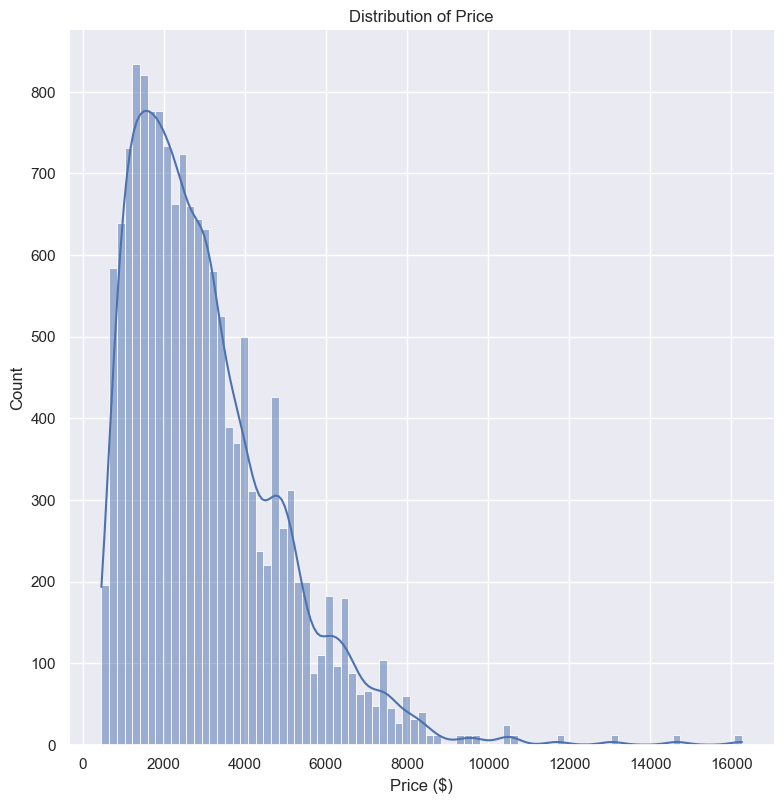

In [331]:
sns.displot(data=pcDf, x="Price ($)", kde=True, height = 8)
plt.title("Distribution of Price")
plt.show()

In [332]:
price_median = pcDf["Price ($)"].median()
price_iqr = pcDf["Price ($)"].quantile(.75) - pcDf["Price ($)"].quantile(.25)
print(f"Median Price: ${price_median}, Price IQR: ${price_iqr}")

Median Price: $2614.426, Price IQR: $2376.6440000000002


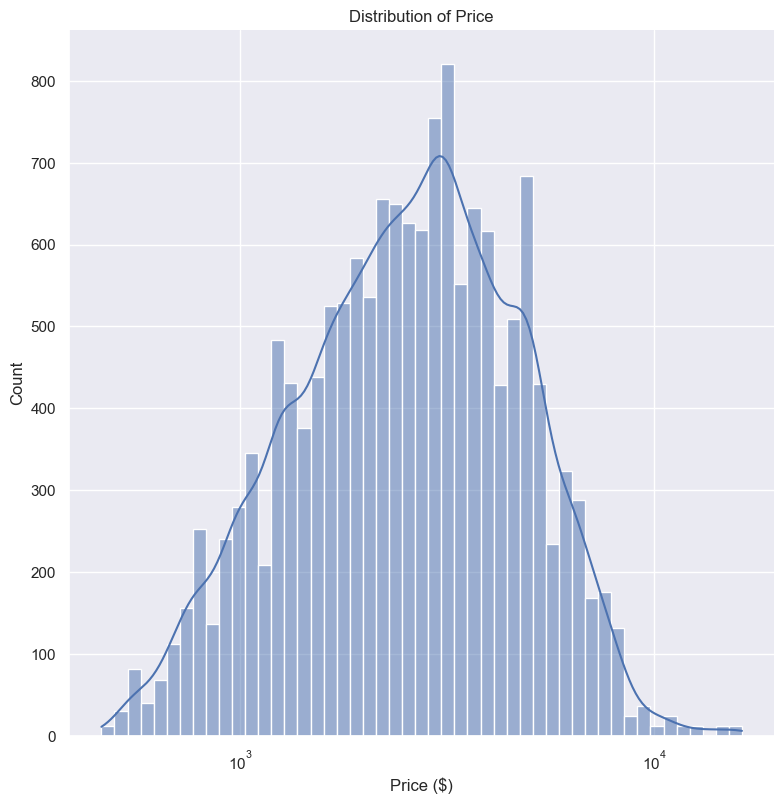

In [333]:
sns.displot(data=pcDf, x="Price ($)", kde=True, height = 8,log_scale=True)
plt.title("Distribution of Price")
plt.show()

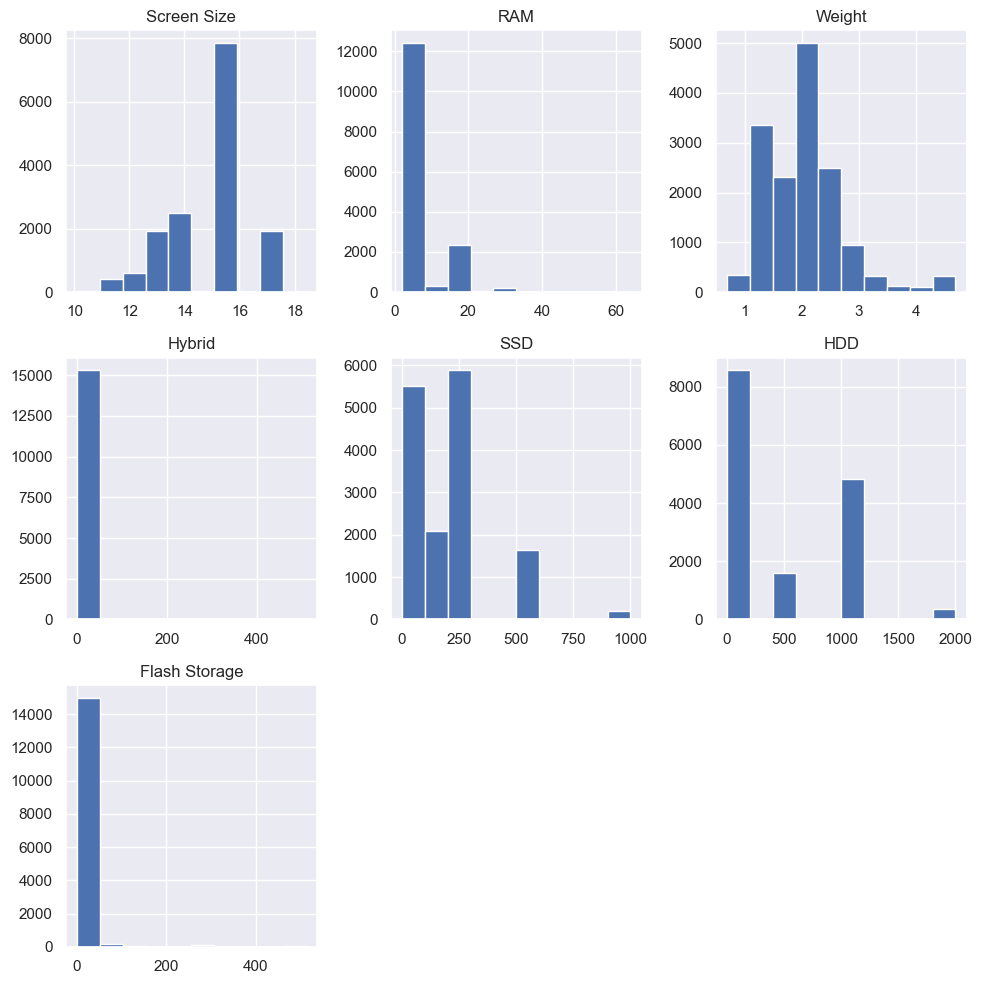

In [334]:
pcDf[quantitativeVariable].hist(figsize=(10, 10))
plt.tight_layout()
plt.show()

C:\Users\zhuof\AppData\Local\Temp\ipykernel_8428\3463863480.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


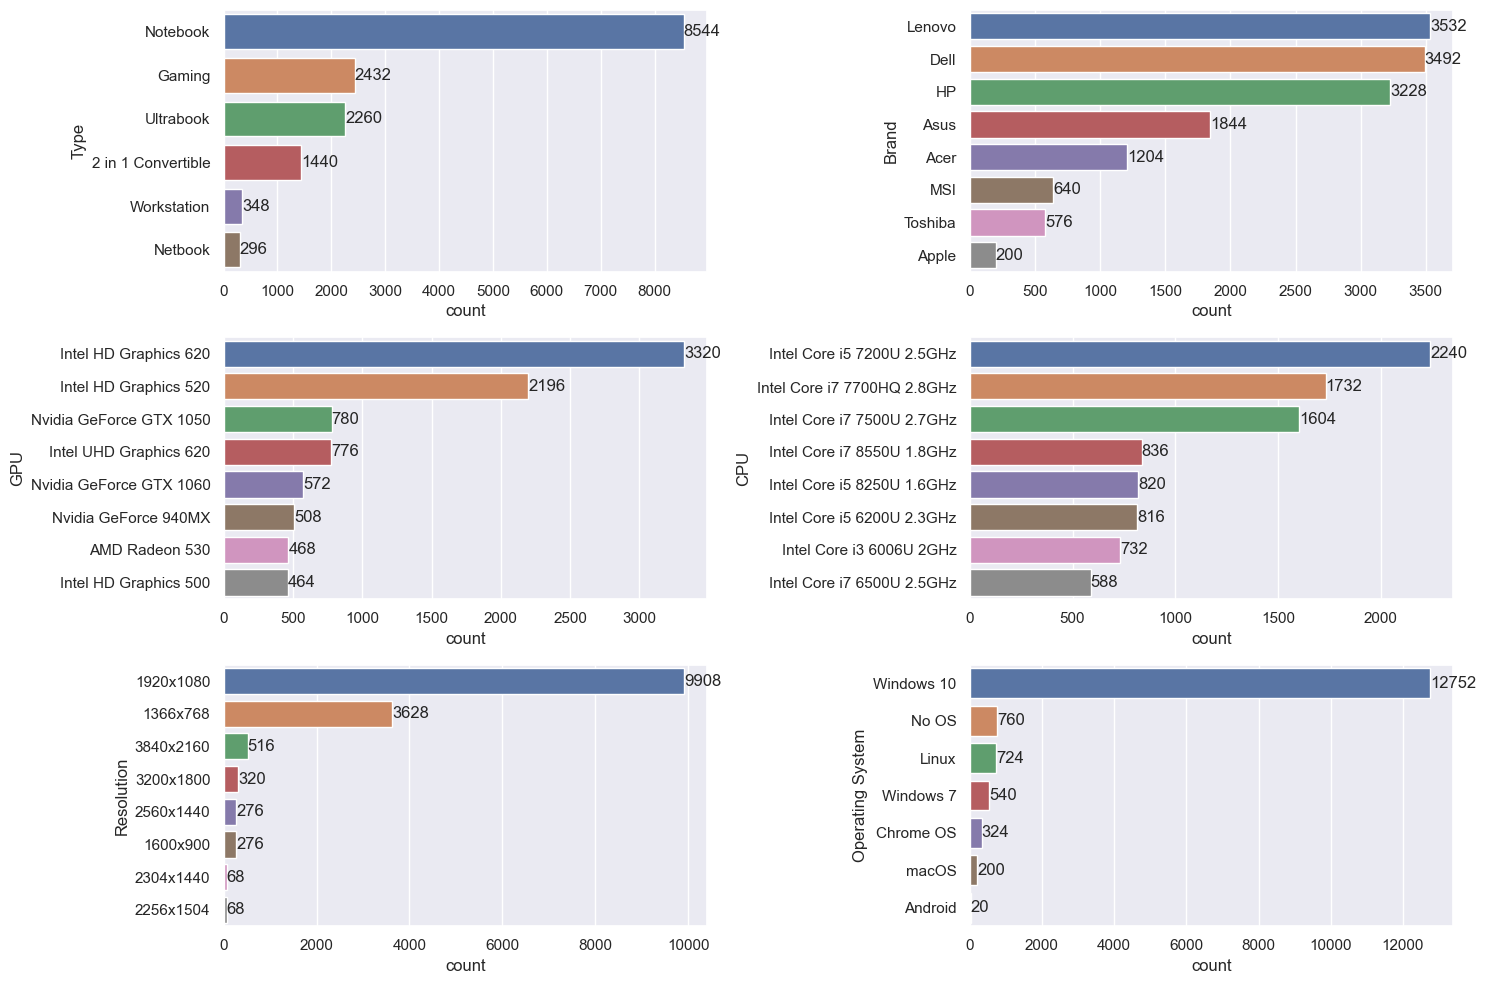

In [335]:
fig, ax = plt.subplots(int(np.ceil(len(qualitativeVariable)/2)), 2, figsize=(15, 10), tight_layout=True)
for i,y in enumerate(qualitativeVariable):
    n=1 if i%2==0 else 0
    g=sns.countplot(y=y,data=pcDf,ax=ax[int(np.floor(i/2)),n],orient='h',order=pcDf[y].value_counts().iloc[:8].index)
    g.bar_label(g.containers[0])
fig.show()

In [336]:
pcDf

,Product ID,Brand,Type,Screen Size,CPU,RAM,GPU,Operating System,Weight,Price ($),SSD,Flash Storage,HDD,Hybrid,Resolution,Touchscreen
0,0,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,8,Intel Iris Plus Graphics 640,macOS,1.37,3568.93416,128,0,0,0,2560x1600,0
1,1,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,macOS,1.34,2394.77616,0,128,0,0,1440x900,0
2,2,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,Intel HD Graphics 620,No OS,1.86,1531.80000,256,0,0,0,1920x1080,0
3,3,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,macOS,1.83,6759.76680,512,0,0,0,2880x1800,0
4,4,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,macOS,1.37,4804.79040,256,0,0,0,2560x1600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15315,15315,Lenovo,2 in 1 Convertible,14.0,Intel Core i7 6500U 2.5GHz,4,Intel HD Graphics 520,Windows 10,1.80,1706.40200,128,0,0,0,1920x1080,1
15316,15316,Lenovo,2 in 1 Convertible,13.3,Intel Core i7 6500U 2.5GHz,16,Intel HD Graphics 520,Windows 10,1.30,4000.10600,512,0,0,0,3200x1800,1
15317,15317,Lenovo,Notebook,14.0,Intel Celeron Dual Core N3050 1.6GHz,2,Intel HD Graphics,Windows 10,1.50,616.82600,0,64,0,0,1366x768,0
15318,15318,HP,Notebook,15.6,Intel Core i7 6500U 2.5GHz,6,AMD Radeon R5 M330,Windows 10,2.19,2042.06600,0,0,1000,0,1366x768,0


### Bivariate Analysis

In [337]:
pcDf=pcDf.drop('Product ID',axis=1)


interval columns not set, guessing: ['Screen Size', 'RAM', 'Weight', 'Price ($)', 'SSD', 'Flash Storage', 'HDD', 'Hybrid', 'Touchscreen']


Text(0.5, 1.0, 'Correlation Matrix')

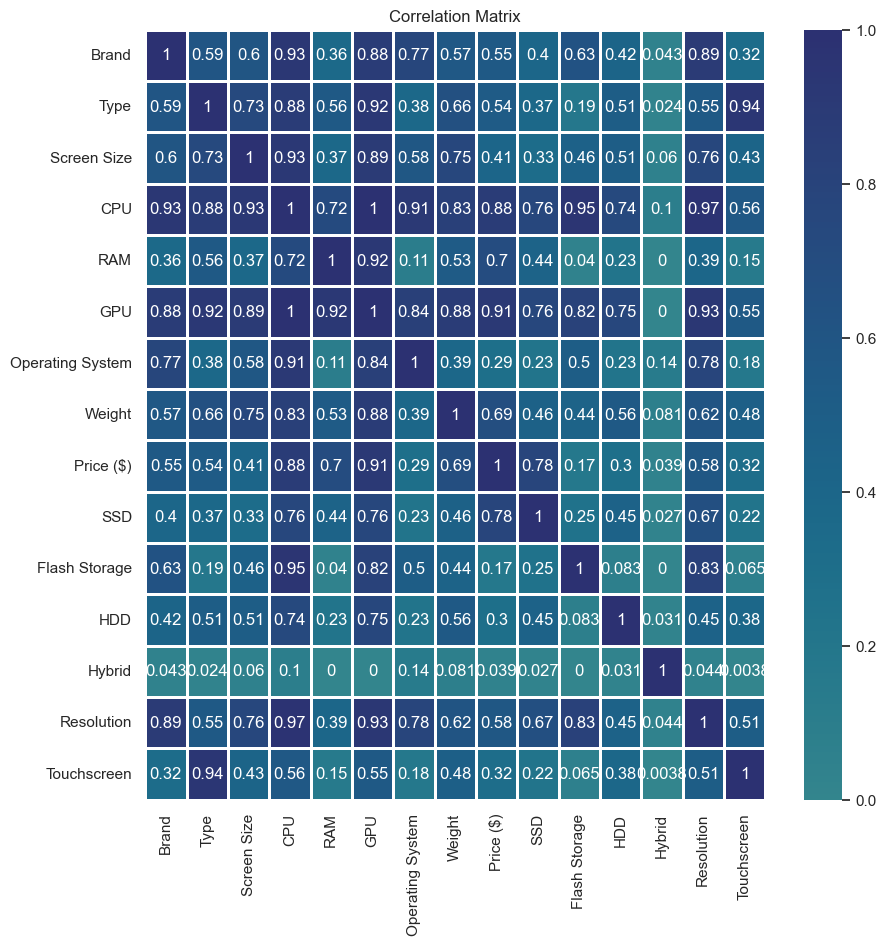

In [338]:
fig, ax = plt.subplots(figsize=(10,10))
# corr_matrix = pcDf.phik_matrix(interval_cols=pcDf.columns)
corr_matrix =pcDf.phik_matrix()
sns.heatmap(corr_matrix, annot = True, linewidths=.8,center = 0,cmap="crest").set_title('Correlation Matrix')

In [339]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [340]:
vifdf=pcDf.copy()
#Label Encoding on the Package attribute
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
#Assigning numerical values and storing in another column
vif=MultiColumnLabelEncoder(columns = qualitativeVariable).fit_transform(vifdf)


vif[quantitativeVariable]=StandardScaler().fit_transform(vif[quantitativeVariable])

In [341]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [342]:
calc_vif(vif)

,variables,VIF
0,Brand,3.714812
1,Type,7.837206
2,Screen Size,3.879407
3,CPU,15.578989
4,RAM,3.142460
5,GPU,11.169277
6,Operating System,18.512263
7,Weight,4.762153
8,Price ($),13.228392
9,SSD,3.179502
